In [587]:
import numpy as np
import matplotlib.pyplot as plt

In [588]:
class Env:
    def reset(self):
        self.state = np.random.randint(7)
        return self.state
    
    def set_state(self, state):
        self.state = state
    
    def step(self, action):
        if action == 0:   # solid action
            self.state = 6
        else:  # dashed action
            self.state = np.random.randint(6)
        
        return self.state, 0

In [589]:
class Agent4:  # TD(0) with gradient correction
    def __init__(self, do=False):
        self.x = np.array([[2., 0, 0, 0, 0, 0, 0, 1],
                           [0, 2, 0, 0, 0, 0, 0, 1],
                           [0, 0, 2, 0, 0, 0, 0, 1],
                           [0, 0, 0, 2, 0, 0, 0, 1],
                           [0, 0, 0, 0, 2, 0, 0, 1],
                           [0, 0, 0, 0, 0, 2, 0, 1],
                           [0, 0, 0, 0, 0, 0, 1, 2]])
        self.w = np.array([1., 1, 1, 1, 1, 1, 10, 1])

        self.v = np.zeros(8)

        self.alpha = 0.005
        self.beta = 0.05
        self.gamma = 0.99

        self.optimal_w = np.array([1., 1, 1, 1, 1, 4, -2])

        if do:
            self.do()

    def do(self):
        self.s_log = []
        self.v_log = []
        self.w_log = []
        self.VE = []
        self.PBE = []
        env = Env()
        state = env.reset()
        for step in range(1000):
            action = np.random.choice(2, p=[1/7, 6/7])
            next_state, reward = env.step(action)

            if action == 0:
                rho = 7
            else:
                rho = 0

            delta = reward + self.gamma * self.w @ self.x[next_state] - self.w @ self.x[state]

            self.w += self.alpha * rho * (delta * self.x[state] - self.gamma * self.x[next_state] * (self.x[state] @ self.v))
            self.v += self.beta * rho * (delta - self.v @ self.x[state]) * self.x[state]

            self.VE.append(self.get_VE(self.w))
            self.PBE.append(self.get_PBE(self.w))
            self.s_log.append(self.x @ self.v)
            self.v_log.append(self.v.copy())
            self.w_log.append(self.w.copy())
            state = next_state

    def get_VE(self, w):
        return np.sqrt(np.mean((self.x @ w - self.optimal_w) ** 2))

    def get_BEV(self, w):
        BEV = np.zeros(7)
        for i in range(7):
            BEV[i] = self.gamma * w @ self.x[6] - w @ self.x[i]

        return BEV

    def get_PBE(self, w):
        D = np.diag([1/7 for _ in range(7)])
        n1 = self.x.T @ D @ self.get_BEV(w)
        n2 = self.x.T @ D @ self.x

        return np.sqrt(n1 @ np.linalg.inv(n2) @ n1)

In [590]:
class Agent5:  # TD(0) with gradient correction - Expectation
    def __init__(self, do=False):
        self.x = np.array([[2., 0, 0, 0, 0, 0, 0, 1],
                           [0, 2, 0, 0, 0, 0, 0, 1],
                           [0, 0, 2, 0, 0, 0, 0, 1],
                           [0, 0, 0, 2, 0, 0, 0, 1],
                           [0, 0, 0, 0, 2, 0, 0, 1],
                           [0, 0, 0, 0, 0, 2, 0, 1],
                           [0, 0, 0, 0, 0, 0, 1, 2]])
        self.w = np.array([1., 1, 1, 1, 1, 1, 10, 1])
        self.v = np.zeros(8)

        self.alpha = 0.005
        self.beta = 0.05
        self.gamma = 0.99

        self.optimal_w = np.array([1., 1, 1, 1, 1, 4, -2])

        if do:
            self.do()

    def do(self):
        self.s_log = []
        self.v_log = []
        self.w_log = []
        self.VE = []
        self.PBE = []
        env = Env()
        state = env.reset()
        for iter in range(1000):
            
            v_delta = np.zeros(8)
            w_delta = np.zeros(8)

            for state in range(7):
                delta = 0 + self.gamma * self.w @ self.x[6] - self.w @ self.x[state]

                w_delta += (delta * self.x[state] - self.gamma * self.x[6] * (self.x[state] @ self.v))
                v_delta += (delta - self.v @ self.x[state]) * self.x[state]

            self.w += self.alpha / 7 * w_delta
            self.v += self.beta / 7 * v_delta

            self.VE.append(self.get_VE(self.w))
            self.PBE.append(self.get_PBE(self.w))
            self.s_log.append(self.x @ self.v)
            self.v_log.append(self.v.copy())
            self.w_log.append(self.w.copy())

    def get_VE(self, w):
        return np.sqrt(np.mean((self.x @ w - self.optimal_w) ** 2))

    def get_BEV(self, w):
        BEV = np.zeros(7)
        for i in range(7):
            BEV[i] = self.gamma * w @ self.x[6] - w @ self.x[i]

        return BEV

    def get_PBE(self, w):
        D = np.diag([1/7 for _ in range(7)])
        n1 = self.x.T @ D @ self.get_BEV(w)
        n2 = self.x.T @ D @ self.x
       

        return np.sqrt(n1 @ np.linalg.pinv(n2) @ n1)

In [591]:
a4 = Agent4(do=True)
a5 = Agent5(do=True)

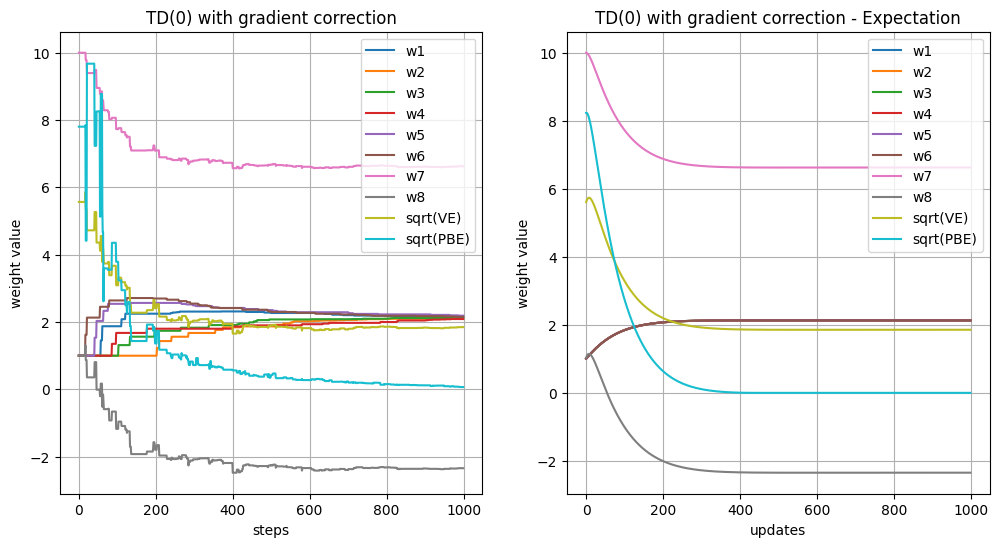

In [592]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(8):
    ax[0].plot([w[i] for w in a4.w_log], label='w'+str(i+1))
    ax[1].plot([w[i] for w in a5.w_log], label='w'+str(i+1))

ax[0].plot(a4.VE, label='sqrt(VE)')
ax[0].plot(a4.PBE, label='sqrt(PBE)')

ax[1].plot(a5.VE, label='sqrt(VE)')
ax[1].plot(a5.PBE, label='sqrt(PBE)')

ax[0].legend()
ax[0].set_xlabel('steps')
ax[0].set_ylabel('weight value')
ax[0].set_title('TD(0) with gradient correction')
ax[0].grid()

ax[1].legend()
ax[1].set_xlabel('updates')
ax[1].set_ylabel('weight value')
ax[1].set_title('TD(0) with gradient correction - Expectation')
ax[1].grid()

plt.show()

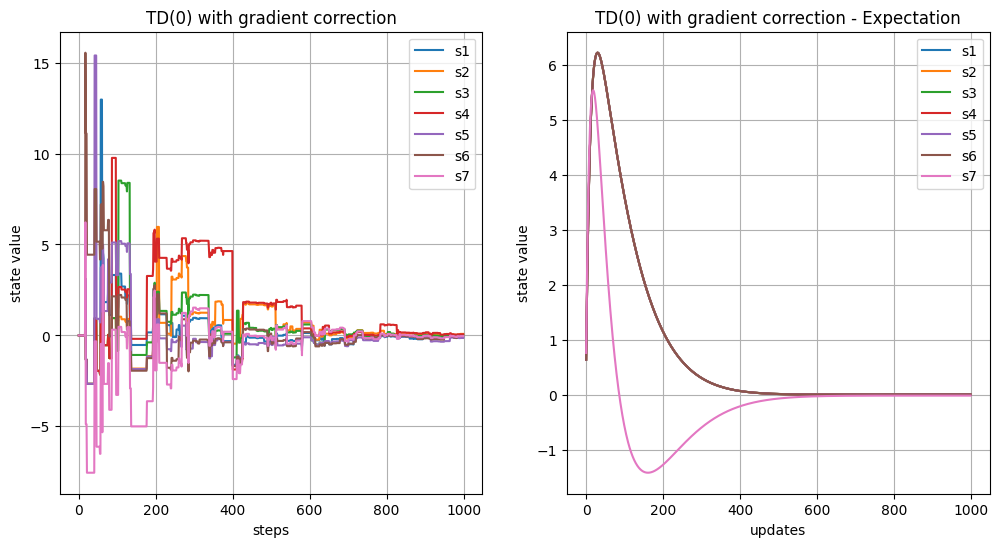

In [593]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(7):
    ax[0].plot([s[i] for s in a4.s_log], label='s'+str(i+1))
    ax[1].plot([s[i] for s in a5.s_log], label='s'+str(i+1))

ax[0].legend()
ax[0].set_xlabel('steps')
ax[0].set_ylabel('state value')
ax[0].set_title('TD(0) with gradient correction')
ax[0].grid()

ax[1].legend()
ax[1].set_xlabel('updates')
ax[1].set_ylabel('state value')
ax[1].set_title('TD(0) with gradient correction - Expectation')
ax[1].grid()

plt.show()

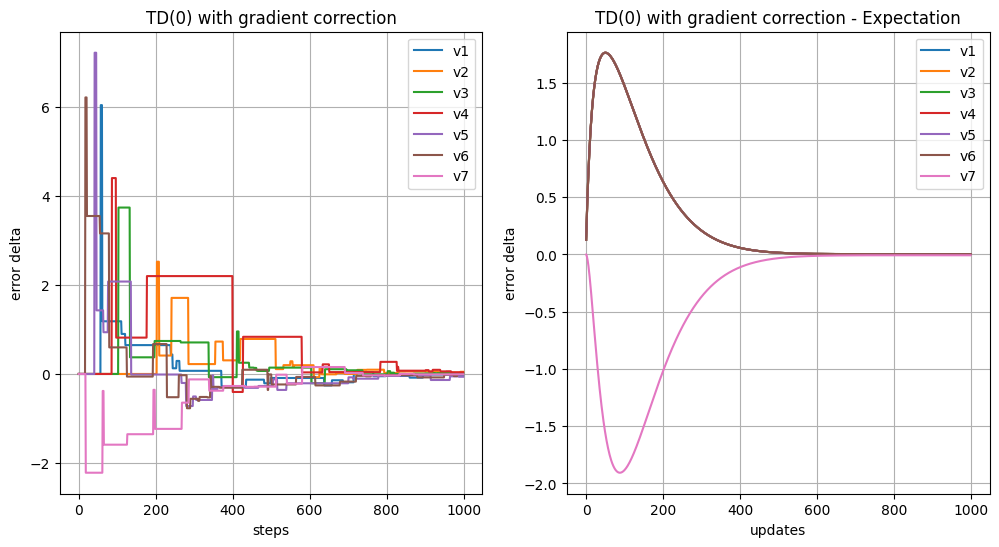

In [594]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(7):
    ax[0].plot([s[i] for s in a4.v_log], label='v'+str(i+1))
    ax[1].plot([s[i] for s in a5.v_log], label='v'+str(i+1))

ax[0].legend()
ax[0].set_xlabel('steps')
ax[0].set_ylabel('error delta')
ax[0].set_title('TD(0) with gradient correction')
ax[0].grid()

ax[1].legend()
ax[1].set_xlabel('updates')
ax[1].set_ylabel('error delta')
ax[1].set_title('TD(0) with gradient correction - Expectation')
ax[1].grid()

plt.show()